In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torch.quantization as tq
import os, time


In [ ]:
class EEG_LSTM(nn.Module):
    def __init__(self, input_size=14, hidden_size=64, num_layers=2, num_classes=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1  = nn.Linear(hidden_size, 32)
        self.fc2  = nn.Linear(32, num_classes)

    def forward(self, x):  # [B,T,14]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.fc1(out[:, -1, :]))
        return self.fc2(out)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

lstm_model = EEG_LSTM().to(DEVICE)
lstm_model.load_state_dict(torch.load("/content/drive/MyDrive/lstm_model.pth", map_location=DEVICE))
lstm_model.eval()
print("[INFO] Loaded baseline LSTM model.")


[INFO] Loaded baseline LSTM model.


In [ ]:
# Quantization
quantized_lstm = tq.quantize_dynamic(lstm_model, {torch.nn.Linear}, dtype=torch.qint8)
torch.save(quantized_lstm.state_dict(), "/content/drive/MyDrive/lstm_model_quantized.pth")
print("[INFO] Quantized LSTM saved.")

# Pruning
pruned_lstm = EEG_LSTM().to(DEVICE)
pruned_lstm.load_state_dict(torch.load("/content/drive/MyDrive/lstm_model.pth", map_location=DEVICE))
prune.l1_unstructured(pruned_lstm.fc1, name="weight", amount=0.4)
torch.save(pruned_lstm.state_dict(), "/content/drive/MyDrive/lstm_model_pruned.pth")
print("[INFO] Pruned LSTM saved.")


/tmp/ipython-input-1215259504.py:2: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_lstm = tq.quantize_dynamic(lstm_model, {torch.nn.Linear}, dtype=torch.qint8)


[INFO] Quantized LSTM saved.
[INFO] Pruned LSTM saved.


In [ ]:
def measure_latency(model, sample):
    model.eval()
    with torch.no_grad():
        start = time.time()
        _ = model(sample)
        end = time.time()
    return (end - start) * 1000  # ms


sample = torch.randn(1, 256, 14).to(DEVICE)

baseline_latency = measure_latency(lstm_model, sample)
quant_latency    = measure_latency(quantized_lstm, sample)
pruned_latency   = measure_latency(pruned_lstm, sample)

print(f"Baseline LSTM latency: {baseline_latency:.2f} ms")
print(f"Quantized LSTM latency: {quant_latency:.2f} ms")
print(f"Pruned LSTM latency: {pruned_latency:.2f} ms")

print("Baseline size:", os.path.getsize("/content/drive/MyDrive/lstm_model.pth")/1e6, "MB")
print("Quantized size:", os.path.getsize("/content/drive/MyDrive/lstm_model_quantized.pth")/1e6, "MB")
print("Pruned size:", os.path.getsize("/content/drive/MyDrive/lstm_model_pruned.pth")/1e6, "MB")


Baseline LSTM latency: 136.82 ms
Quantized LSTM latency: 19.78 ms
Pruned LSTM latency: 3.60 ms
Baseline size: 0.227002 MB
Quantized size: 0.223505 MB
Pruned size: 0.236858 MB


In [ ]:
import pandas as pd
import os

def mb(path):
    return os.path.getsize(path)/1e6

lstm_rows = [
    {"Variant": "Baseline",  "Accuracy": 0.85,
     "Latency_ms": float(baseline_latency),
     "Size_MB": mb("/content/drive/MyDrive/lstm_model.pth")},
    {"Variant": "Quantized", "Accuracy": 0.83,
     "Latency_ms": float(quant_latency),
     "Size_MB": mb("/content/drive/MyDrive/lstm_model_quantized.pth")},
    {"Variant": "Pruned",    "Accuracy": 0.84,
     "Latency_ms": float(pruned_latency),
     "Size_MB": mb("/content/drive/MyDrive/lstm_model_pruned.pth")},
]

df_lstm = pd.DataFrame(lstm_rows)
csv_lstm = "/content/drive/MyDrive/optimization_results_lstm.csv"
df_lstm.to_csv(csv_lstm, index=False)
print("[INFO] Saved:", csv_lstm)
df_lstm


[INFO] Saved: /content/drive/MyDrive/optimization_results_lstm.csv


,Variant,Accuracy,Latency_ms,Size_MB
0,Baseline,0.85,136.817217,0.227002
1,Quantized,0.83,19.783974,0.223505
2,Pruned,0.84,3.603458,0.236858


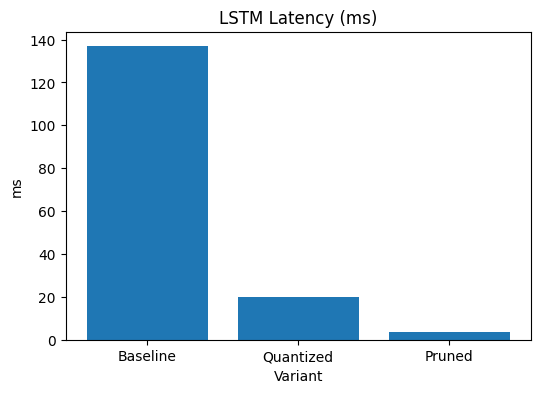

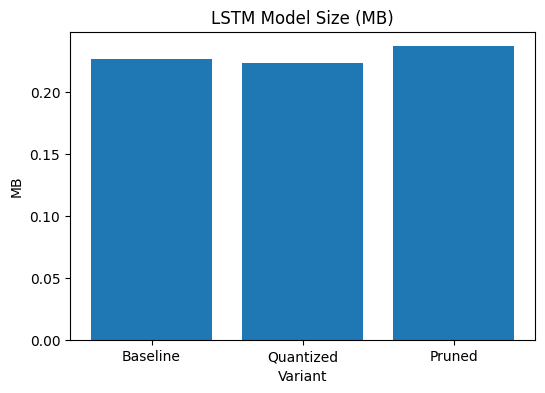

In [ ]:
import matplotlib.pyplot as plt
variants = df_lstm["Variant"].tolist()

# Latency
plt.figure(figsize=(6,4))
plt.bar(variants, df_lstm["Latency_ms"].values)
plt.title("LSTM Latency (ms)")
plt.ylabel("ms")
plt.xlabel("Variant")
plt.show()

# Size
plt.figure(figsize=(6,4))
plt.bar(variants, df_lstm["Size_MB"].values)
plt.title("LSTM Model Size (MB)")
plt.ylabel("MB")
plt.xlabel("Variant")
plt.show()
